## ***Importing libraries***

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim import AdamW
from keras.datasets import mnist
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
custom = {"axes.edgecolor": "black", "grid.linestyle": "dashed", "grid.color": "gray"}
sns.set_style("darkgrid", rc = custom)

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## ***Normilize values of pixels intensity***

In [12]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [13]:
def plot_img(img, label):
    fig = plt.figure(figsize=(3, 3))
    plt.imshow(img.reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    plt.title(label)

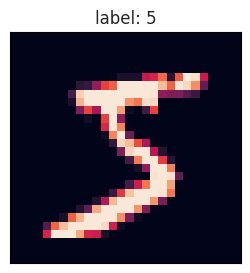

In [15]:
plot_img(X_train[0], f'label: {y_train[0]}')

## ***Making Dataset-class for images***

In [16]:
class MNIST(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index]), torch.tensor(self.labels[index])

In [17]:
train_data = MNIST(X_train, y_train)
test_data = MNIST(X_test, y_test)

In [18]:
train_loader = DataLoader(train_data, 32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, 32)

In [21]:
train_data[0][0].shape

torch.Size([28, 28])

## ***Making our NN architecture***

In [70]:
class Net(nn.Module):
    def __init__(self, hidden_dims, output_dim, stride, padding, channels, kernel_size):
        super(Net, self).__init__()
        self.convolutions = nn.Sequential(
            nn.Conv2d(
                in_channels=channels,
                out_channels=6,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            ),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=padding),
            nn.Conv2d(
                in_channels=6,
                out_channels=16,
                kernel_size=kernel_size
            ),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=padding),
        )

        self.layers = nn.Sequential(
            nn.Linear(400, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], output_dim)
        )
    def forward(self, x):
        x = self.convolutions(x)
        x = x.flatten(start_dim=1)
        return self.layers(x)

In [71]:
stride = 1
padding = 0
channels = 1
kernel_size = 3

In [77]:
input_dim = 784
hidden_dims = [512, 256]
output_dim = np.unique(y_train).shape[0]
lr = 0.001
epochs = 5

In [78]:
model = Net(hidden_dims, output_dim, stride, padding, channels, kernel_size)

In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(params=model.parameters(), lr=lr)

## ***Training process***

In [80]:
model.train()

for epoch in range(epochs):
    epoch_loss = []
    for batch in tqdm(train_loader):
        X_batch, y_batch = batch
        optimizer.zero_grad()
        outputs = model(X_batch.to(torch.float32).unsqueeze(1))
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    print(np.mean(epoch_loss))


100%|██████████| 1875/1875 [00:29<00:00, 63.59it/s]


0.18255094152769694


100%|██████████| 1875/1875 [00:30<00:00, 61.26it/s]


0.06177138219514551


100%|██████████| 1875/1875 [00:28<00:00, 64.98it/s]


0.04364168322142214


100%|██████████| 1875/1875 [00:29<00:00, 64.48it/s]


0.03279126876489027


100%|██████████| 1875/1875 [00:28<00:00, 64.77it/s]

0.025502502326017324


In [82]:
model.eval()
accuracies = []

for batch in test_loader:
    with torch.no_grad():
        out = model(batch[0].unsqueeze(1).to(torch.float32))
    predictions = out.argmax(axis=-1)
    accuracies.append(accuracy_score(predictions, batch[1]))

print(np.mean(accuracies))

0.9886182108626198
